In [ ]:
import time
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from selectinf.Simulation.simulation_helpers import (one_sim_mode, one_sim_mode_serial,
                                generate_gaussian_instance_nonlinear_interaction_simple,
                                generate_gaussian_instance_nonlinear_interaction,
                                )
from selectinf.Simulation.spline_instance import (generate_gaussian_instance_from_bspline_interaction, generate_gaussian_instance_nonlinear_interaction,
 gaussian_group_polynomial_interaction_instance)
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
from selectinf.Simulation.simulation_helpers import (naive_inference_inter, data_splitting_inter,
                                MLE_inference_inter,
                                calculate_F1_score_interactions)
from selectinf.Simulation.spline_instance import (
    generate_gaussian_instance_nonlinear_interaction_block)
from multiprocessing import Pool

from functools import partial

In [79]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)
    
    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    
    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

In [142]:
(design, data_interaction, Y, Y_mean, X,
 active, active_inter_adj, active_inter_list, groups, gamma) \
        = gaussian_group_polynomial_interaction_instance(n=100,
                                                         p=50,
                                                         s=2,
                                                         rho=0.5, full_corr=True,
                                                         rho_noise=0.5,
                                                         equicorrelated=True,
                                                         SNR = 1,
                                                         order=2,
                                                         interaction_signal=1,
                                                         random_signs=False,
                                                         scale=False,
                                                         center=True,
                                                         structure='stronghierarchy',
                                                         s_interaction=1,
                                                         intercept=True)

noise_sd: 0.44030337127872177


In [41]:
const = group_lasso.gaussian
coverages, lengths, selected_inter, p_values, targets \
    = naive_inference_inter(X=design, Y=Y, groups=groups,
                            Y_mean=Y_mean, const=const,
                            n_features=10, interactions=data_interaction,
                            weight_frac=5, level=0.9, mode='weakhierarchy',
                            solve_only=False, continued=False,
                            parallel=False, p_val=True, return_pivot=True,
                            intercept=True)

[0, 1, 2, 4, 6, 7, 8, 9, 10]
8.0
Naive Selection Size: 3


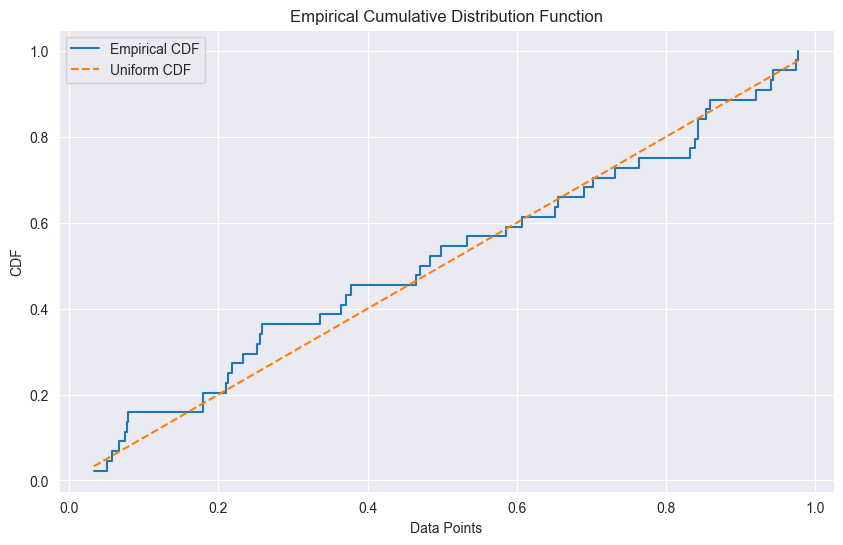

In [42]:
plot_ecdf(p_values)

In [211]:
oper_char = {}
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["rho"] = []
oper_char["target"] = []
oper_char["pval"] = []
const = group_lasso.gaussian
#p = 50
#rho = 0.5
#signal = 0
weights = 0.5
for i in range(500):
    for rho in [0.75]:
        while True:
            (design, data_interaction, Y, Y_mean, X,
             active, active_inter_adj, active_inter_list, groups, gamma) \
                = (gaussian_group_polynomial_interaction_instance
                   (n=500, p=20, s=5, rho=rho, full_corr=True, rho_noise=rho,
                    equicorrelated=True, SNR = 0, order=2, interaction_signal=0,
                    random_signs=False, scale=True, center=False, 
                    structure='weakhierarchy', s_interaction=5, intercept=True))
            #active_inter_list = [(x[0],x[1]) for x in active_inter_list]
            active_inter_list = [(0,1)]
            
            noselection = False
            
            if not noselection:
                coverages, lengths, selected_inter, p_values, targets \
                    = naive_inference_inter(X=design, Y=Y, groups=groups,
                                            Y_mean=Y_mean, const=const,
                                            n_features=20, interactions=data_interaction,
                                            weight_frac=weights, level=0.9,
                                            mode='weakhierarchy',
                                            solve_only=False, continued=False,
                                            parallel=False, p_val=True, return_pivot=True,
                                            intercept=True, target_ids=active_inter_list)
            
                noselection = coverages is None
                    
            if not noselection:
                coverages_ds, lengths_ds, selected_inter_ds, p_values_ds, targets_ds \
                    = data_splitting_inter(X=design, Y=Y, groups=groups,
                                           Y_mean=Y_mean, const=const,
                                           n_features=20, interactions=data_interaction,
                                           proportion=0.5, weight_frac=weights,
                                           level=0.9, 
                                           mode='weakhierarchy', solve_only=False, 
                                           continued=False, parallel=False,
                                           p_val=True, return_pivot=True, intercept=True,
                                           target_ids=active_inter_list)
            
                noselection = coverages_ds is None
                
            if not noselection:
                coverages_MLE, lengths_MLE, selected_inter_MLE, p_values_MLE, targets_MLE\
                    = MLE_inference_inter(X=design, Y=Y, Y_mean=Y_mean, groups=groups,
                                          n_features=20, interactions=data_interaction,
                                          intercept=True, proportion=0.5, 
                                          weight_frac=weights, level=0.9,
                                          mode='weakhierarchy', solve_only=False,
                                          continued=False, parallel=False, p_val=True, 
                                          return_pivot=True, target_ids=active_inter_list)
                noselection = coverages_MLE is None
            
            if not noselection:
                # Naive
                oper_char["coverage rate"].append(np.mean(coverages))
                oper_char["avg length"].append(np.mean(lengths))
                oper_char["method"].append('Naive')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets[0])
                oper_char["pval"].append(p_values[0])
    
                # Data splitting
                oper_char["coverage rate"].append(np.mean(coverages_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["method"].append('Data Splitting')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets_ds[0])
                oper_char["pval"].append(p_values_ds[0])
                
                # MLE
                oper_char["coverage rate"].append(np.mean(coverages_MLE))
                oper_char["avg length"].append(np.mean(lengths_MLE))
                oper_char["method"].append('MLE')
                oper_char["rho"].append(rho)
                oper_char["target"].append(targets_MLE[0])
                oper_char["pval"].append(p_values_MLE[0])
                
                break

[0, 4, 7, 9, 20]
[0, 2, 5, 6]
3.0
Naive Selection Size: 1
[0, 7, 15]
[0, 5, 8]
[0, 3, 12]
[0, 2, 9]
2.0
Naive Selection Size: 0
3.0
DS Selection Size: 0
12.0
0 th interaction out of 1
Z-values: 0.6905538194619044
[0, 3, 4, 10]
[0, 7, 14, 16]
[0, 9, 12]
[0, 19, 20]
[0, 2, 8, 20]
3.0
Naive Selection Size: 0
6.0
DS Selection Size: 0
[0, 1, 4]
2.0
Naive Selection Size: 0
[0, 16, 19]
[0, 7, 9]
[0, 8, 9, 16, 17]
[0, 7, 19, 20]
[0, 3, 10, 20]
[0, 8, 9]
[0, 2, 5, 9]
3.0
Naive Selection Size: 1
6.0
DS Selection Size: 1
13.0
0 th interaction out of 1
Z-values: -0.8939605257531015
[0, 9, 13, 16]
[0, 4, 13, 18]
[0, 4, 17]
[0, 6, 11]
[0, 3, 9, 10, 18]
[0, 2, 10, 14]
3.0
Naive Selection Size: 0
8.0
DS Selection Size: 0
8.0
0 th interaction out of 1
Z-values: 0.3769762511104717
[0, 2, 3, 5]
3.0
Naive Selection Size: 0
5.0
DS Selection Size: 0
[0, 2, 18]
2.0
Naive Selection Size: 0
9.0
DS Selection Size: 0
11.0
0 th interaction out of 1
Z-values: 2.2513024462042055
[0, 6, 17]
[0, 2, 16]
2.0
Naive Sele

# Plotting the ECDFs of Pivots of All Methods

In [220]:
def plot_ecdf_by_method(values, labels, rho_list):
    values = np.array(values)
    labels = np.array(labels)
    rho_list = np.array(rho_list)
    # Function to calculate ECDF
    def ecdf(data):
        x = np.sort(data)
        n = x.size
        y = np.arange(1, n+1) / n
        return x, y
    
    my_palette = {"MLE": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=len(list(np.unique(rho_list))), 
                             figsize=(5*len(list(np.unique(rho_list))), 5))
    if len(list(np.unique(rho_list))) > 1:
        axes_list = axes.flatten()
    else:
        axes_list = [axes]
    i = 0
    for ax in axes_list:
        rho = np.unique(rho_list)[i]
        values_i = values[rho_list == rho]
        labels_i = labels[rho_list == rho]
    
        # Create a DataFrame
        df = pd.DataFrame({'Values': values_i, 'Distribution': labels_i})

        # Plotting
        for distribution in df['Distribution'].unique():
            x, y = ecdf(df[df['Distribution'] == distribution]['Values'])
            ax.plot(x, y, marker='.', linestyle='none', label=distribution,
                    color=my_palette[distribution])
    
        # Add y = x line
        ax.plot([0, 1], [0, 1], 'k--', label='y = x')

        ax.set_title('$rho=$'+str(rho))
        ax.set_xlabel('Value')
        ax.set_ylabel('ECDF')
        ax.axis(xmin=0.,xmax=1, ymin=0., ymax=1)
        ax.legend()
        ax.grid(True)
        i += 1
    # Adjust layout to prevent overlap
    plt.tight_layout()
    #plt.legend(handles, labels, loc='lower center', ncol=4)
    plt.show()

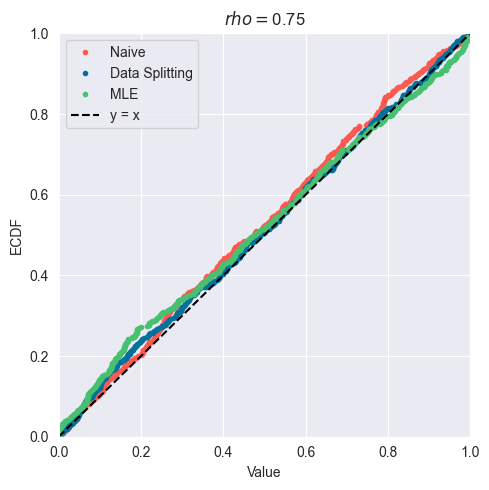

In [221]:
plot_ecdf_by_method(values=oper_char["pval"], labels=oper_char["method"],
                    rho_list=oper_char["rho"])